In this short demo, we studies the different strategies of market makers, using **pyspark** > 2.4.4 and **LOBSTER** data constructed by the new **LOBSTER** engine running on cloud setting.

## Prerequisite Packages
Several packages need to be installed:
1. **pyspark** or a full **spark** installation following [here] <https://spark.apache.org/downloads.html>. 
1. **numpy** and **pandas** as expected
1. **seabon** for graphic presentation
1. **pyarrow** is **NOT** required in current stage, but better to get it ready.

In [1]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
from pyspark.sql import DataFrame
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from datetime import date
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set()
pd.options.display.max_columns = None

%matplotlib inline

date = '2017-11-15'
symbol = 'AMZN'

## Initialize Spark 
Note that although **Apache Arrow** is a powerful tool to accelerate the convertion between spark dataframe and pandas dataframe, it hit a problem when there is a ``date`` column in the data set. Therefore, I have to disable the feature.

In [2]:
# Enable Apache Arrow to fast convert Spark dataframe to Pandas dataframe

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Load data") \
    .config("spark.driver.memory", "4G") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

Because **pyarrow** has a issue to convert ``date`` data type in spark dataframe to pandas dataframe, we have to cast ``date`` to ``timestamp`` 

In [3]:
orderbookFile = spark.read.parquet("/home/ruihong/lobster4test/itch-derived/orderbook") \
.withColumn("date_temp", (col("date").cast("timestamp"))) \
.drop("date") \
.withColumnRenamed("date_temp", "date")


orderbookFile.createOrReplaceTempView("orderbook")

Investigate the schemas and some data

In [4]:
orderbookFile.printSchema()

root
 |-- sequenceNumber: long (nullable = true)
 |-- Bid_1_price: double (nullable = true)
 |-- Bid_1_quantity: double (nullable = true)
 |-- Bid_2_price: double (nullable = true)
 |-- Bid_2_quantity: double (nullable = true)
 |-- Offer_1_price: double (nullable = true)
 |-- Offer_1_quantity: double (nullable = true)
 |-- Offer_2_price: double (nullable = true)
 |-- Offer_2_quantity: double (nullable = true)
 |-- time: long (nullable = true)
 |-- eventType: string (nullable = true)
 |-- orderId: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- side: string (nullable = true)
 |-- effectiveQuantity: long (nullable = true)
 |-- effectivePrice: long (nullable = true)
 |-- attribution: string (nullable = true)
 |-- matchNumber: long (nullable = true)
 |-- liqGrp: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- date: timestamp (nullable = true)



In [5]:
orderbookFile.limit(5).toPandas().head()

,sequenceNumber,Bid_1_price,Bid_1_quantity,Bid_2_price,Bid_2_quantity,Offer_1_price,Offer_1_quantity,Offer_2_price,Offer_2_quantity,time,eventType,orderId,symbol,side,effectiveQuantity,effectivePrice,attribution,matchNumber,liqGrp,level,date
0,125201640,1699500.0,100.0,1699400.0,29.0,1700400.0,35.0,1701000.0,100.0,34200025913752,Submission,9518437,AAPL,Sell,35,1700400,,0,1,2,2017-11-15
1,125201840,1699500.0,100.0,1699400.0,29.0,1700400.0,135.0,1701000.0,100.0,34200025959228,Submission,9518469,AAPL,Sell,100,1700400,,0,1,2,2017-11-15
2,125203230,1699500.0,100.0,1699400.0,29.0,1700400.0,35.0,1701000.0,100.0,34200026293628,Deletion,9518469,AAPL,Sell,100,1700400,,0,1,2,2017-11-15
3,125207540,1699500.0,100.0,1699400.0,29.0,1700400.0,135.0,1701000.0,100.0,34200027368600,Submission,9519165,AAPL,Sell,100,1700400,,0,1,2,2017-11-15
4,125223160,1699500.0,100.0,1699400.0,29.0,1700400.0,135.0,1701000.0,100.0,34200030550133,HiddenOrderExecution,0,AAPL,Buy,100,1700100,,45711,1,2,2017-11-15


In [6]:
spark.sql(f"select symbol, date, count(*) as numberbook from orderbook group by symbol, date").toPandas().head(20)

,symbol,date,numberbook
0,ASML,2017-11-15,68743
1,MDLZ,2017-11-16,198361
2,EXC,2017-11-16,134225
3,BIDU,2017-11-16,45312
4,SNPS,2017-11-15,22839
5,GILD,2017-11-16,93417
6,CHTR,2017-11-16,37381
7,MXIM,2017-11-16,77134
8,EA,2017-11-16,55896
9,CMCSA,2017-11-16,401262


In [7]:
orderBookSparkDf = spark.sql(f"select * from orderbook where date='{date}' and symbol='{symbol}'")
orderBookPandasDf = orderBookSparkDf.toPandas()
orderBookPandasDf['timestamp'] = pd.to_datetime(orderBookPandasDf['date']) + pd.to_timedelta(orderBookPandasDf['time']/1e9, unit='s')

orderBookPandasDf.head()

,sequenceNumber,Bid_1_price,Bid_1_quantity,Bid_2_price,Bid_2_quantity,Offer_1_price,Offer_1_quantity,Offer_2_price,Offer_2_quantity,time,eventType,orderId,symbol,side,effectiveQuantity,effectivePrice,attribution,matchNumber,liqGrp,level,date,timestamp
0,125143950,11270000.0,507.0,11267800.0,100.0,11271600.0,76.0,11284800.0,20.0,34200016481947,HiddenOrderExecution,0,AMZN,Buy,3,11270500,,45384,2,2,2017-11-15,2017-11-15 09:30:00.016481947
1,125330250,11270000.0,507.0,11267800.0,100.0,11271600.0,76.0,11284800.0,20.0,34200071354238,HiddenOrderExecution,0,AMZN,Buy,3,11270500,,46240,2,2,2017-11-15,2017-11-15 09:30:00.071354238
2,125406470,11270000.0,507.0,11267800.0,100.0,11271600.0,76.0,11284800.0,20.0,34200082349479,HiddenOrderExecution,0,AMZN,Buy,36,11270100,,46364,2,2,2017-11-15,2017-11-15 09:30:00.082349479
3,125443000,11270000.0,507.0,11267800.0,100.0,11271600.0,76.0,11284800.0,20.0,34200141846795,HiddenOrderExecution,0,AMZN,Buy,69,11270500,,46549,2,2,2017-11-15,2017-11-15 09:30:00.141846795
4,125443010,11270000.0,507.0,11267800.0,100.0,11271600.0,69.0,11284800.0,20.0,34200141846795,Execution,9441073,AMZN,Sell,7,11271600,,46550,2,2,2017-11-15,2017-11-15 09:30:00.141846795


Plot the bid and ask

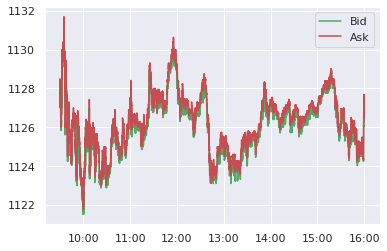

In [8]:
import matplotlib.dates as mdates
timeFormatter = mdates.DateFormatter('%H:%M')

plt.plot(orderBookPandasDf['timestamp'], orderBookPandasDf['Bid_1_price']/10000, color='g', label='Bid')
plt.plot(orderBookPandasDf['timestamp'], orderBookPandasDf['Offer_1_price']/10000, color='r', label='Ask')
plt.gca().xaxis.set_major_formatter(timeFormatter)
plt.legend()
plt.show()